In [2]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import os  
from scipy.signal import butter, filtfilt,lfilter
from sklearn.preprocessing import RobustScaler

In [3]:
# loading and preprocessing data 
def preprocess(directory):
    csv_files=[f for f in os.listdir(directory) if f.endswith('.csv')]  
    all_data=[]
    for i in csv_files:
        df=pd.read_csv(os.path.join(directory, i))  
        df.columns=['Output1','Output2','Output3','Output4','Output5','Output6','Output7','Output8'] 
        data=df.iloc[:, :4]  
        all_data.append(data) 
    my_data=pd.concat(all_data, ignore_index=True) 

    return my_data



In [4]:
data=preprocess('collected data')

In [5]:
print(data)

             Output1       Output2       Output3       Output4
0             300107        233298        180506        170026
1             300069        233186        180483        170026
2             300029        233094        180408        170018
3             300065        233188        180442        170023
4             300114        233363        180554        170023
...              ...           ...           ...           ...
391648        391839        311223        851523        807464
391649        392079        311234        852097        807579
391650        392190        311238        852394        807682
391651        392113        311244        852228        807680
391652  end five.jpg  end five.jpg  end five.jpg  end five.jpg

[391653 rows x 4 columns]


In [6]:
start_markers = ['start one.png', 'start five.jpg', 'start nine.jpg', 'start six.jpg', 'start zero.png', 'start animal.jpg', 'start four.jpg', 'start eight.jpg', 'start three.jpg', 'start seven.jpg', 'start two.jpg']
end_markers = ['end one.png', 'end five.jpg', 'end nine.jpg', 'end six.jpg', 'end zero.png', 'end animal.jpg', 'end four.jpg', 'end eight.jpg', 'end three.jpg', 'end seven.jpg', 'end two.jpg']

In [7]:
def extract_center_rows(data, start_range, end_range, length):
    if start_range > end_range:
        raise ValueError("start_range should be less than or equal to end_range")
    
    if end_range - start_range < length:
        return False, 0
    
    range_data = data.loc[start_range:end_range]
    if length > len(range_data):
        raise ValueError("The specified length is greater than the number of rows in the range")
    
    center_index = len(range_data) // 2
    start_index = max(0, center_index - length // 2)
    end_index = start_index + length
    center_rows = range_data.iloc[start_index:end_index]
    
    return True, center_rows

In [8]:
def extract_data_between_markers(data, start_markers, end_markers, datashape):
    X = []
    Y = []
    between_markers = False
    label = None
    start_idx = None
    end_idx = None
    df_temp = []
    segment_lengths = []
    
    marker_to_label = {
        'start one.png': 1, 'end one.png': 1,
        'start two.jpg': 2, 'end two.jpg': 2,
        'start three.jpg': 3, 'end three.jpg': 3,
        'start four.jpg': 4, 'end four.jpg': 4,
        'start five.jpg': 5, 'end five.jpg': 5,
        'start six.jpg': 6, 'end six.jpg': 6,
        'start seven.jpg': 7, 'end seven.jpg': 7,
        'start eight.jpg': 8, 'end eight.jpg': 8,
        'start nine.jpg': 9, 'end nine.jpg': 9,
        'start zero.png': 0, 'end zero.png': 0,
        'start animal.jpg': -1, 'end animal.jpg': -1
    }
    
    for index, row in data.iterrows():
        if row.iloc[0] in start_markers:
            label = marker_to_label[row.iloc[0]]
            start_idx = index
            between_markers = True
            df_temp = []
            print(f"Start marker found at index {index}, label {label},{row.iloc[0]}")
        elif row.iloc[0] in end_markers:
            if between_markers and len(df_temp) > 0:
                end_idx = index
                success, extracted_data = extract_center_rows(data, start_idx, end_idx, datashape[0])
                if success:
                    X.append(extracted_data.values.astype(float))
                    Y.append(label)
                    print(f"End marker found at index {index}, segment length {len(df_temp)}")
                segment_lengths.append(len(df_temp))
            between_markers = False
        elif between_markers:
            df_temp.append(row.iloc[:4].values.tolist())
    
    X = np.array(X)
    Y = np.array(Y)
    
    print("Total segments found:", len(segment_lengths))
    print("Segment lengths:", segment_lengths)
    print("Number of segments meeting length requirement:", len(X))
    
    return X, Y

In [9]:
datashape = (1000, 4)

X, Y = extract_data_between_markers(data, start_markers, end_markers, datashape)


print("X shape:", X.shape)
print("Y shape:", Y.shape)

print("Unique labels in Y:", np.unique(Y))

Start marker found at index 2431, label 4,start four.jpg
End marker found at index 3712, segment length 1280
Start marker found at index 4353, label 8,start eight.jpg
End marker found at index 5634, segment length 1280
Start marker found at index 6147, label 3,start three.jpg
End marker found at index 7428, segment length 1280
Start marker found at index 8066, label 7,start seven.jpg
End marker found at index 9222, segment length 1155
Start marker found at index 9863, label 1,start one.png
End marker found at index 11144, segment length 1280
Start marker found at index 11785, label -1,start animal.jpg
End marker found at index 13066, segment length 1280
Start marker found at index 13835, label 6,start six.jpg
End marker found at index 15116, segment length 1280
Start marker found at index 15885, label 0,start zero.png
End marker found at index 17166, segment length 1280
Start marker found at index 17935, label 5,start five.jpg
End marker found at index 19344, segment length 1408
Start 

In [10]:
print(Y)

[ 4  8  3  7  1 -1  6  0  5  2  9  2  6  0  3  7  4  1 -1  5  8  9  7  4
 -1  2  0  3  8  1  5  9  6  4  2 -1  7  9  8  5  6  1  0  3  7  1  0  9
  5  3  2  4  8 -1  6  0  7  4  3  6  8 -1  1  2  5  9  4  3 -1  0  6  5
  7  3  9  2  7  5  8  1  6 -1  4  0  1  0 -1  2  4  9  5  3  7  8  6  3
  7  2  8  4  1  5  6  9  0 -1  2  9  6  8  3  4  5  7 -1  0  1  1  5  9
  6  0 -1  4  8  3  7  2  4  6  9  0  5  2  8  1 -1  3  7  0  6  7  4  5
  8  1 -1  9  2  3  2  3 -1  4  6  0  8  7  5  9  1  4  9 -1  1  8  0  3
  7  6  5  2 -1  7  2  9  8  0  1  3  4  6  5]


In [11]:
y_binary=[]
for i in Y: 
    if i in [1, 2, 3, 4, 5, 6, 7, 8, 9]: 
        y_binary.append(0) 
    else:
        y_binary.append(1)
print(y_binary)


[0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]


In [12]:
scaler = RobustScaler()
scaler.fit(X[0])
for i,x in enumerate(X):
    X[i] = scaler.transform(x)

In [13]:
from sklearn.model_selection import train_test_split 
x_train,x_test,y_train,y_test = train_test_split(X,y_binary,test_size=0.2) 


In [14]:
from sklearn.utils.class_weight import compute_class_weight  
class_labels = np.unique(y_train)
class_weights = compute_class_weight(class_weight='balanced',classes=np.unique(y_train), y=list(y_train))

In [15]:
class_weights_dict = dict(zip(class_labels, class_weights)) 
print(class_weights_dict)


{0: 0.6083333333333333, 1: 2.8076923076923075}


In [16]:
from tensorflow.keras.layers import Dense,Flatten,Conv1D,MaxPooling1D,Dropout 
from tensorflow.keras.models import Sequential

/Users/shrutisekhar/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [17]:
y_train=np.expand_dims(y_train,1) 
y_test=np.expand_dims(y_test,1)

In [18]:
model = Sequential([
    Conv1D(32, 3, activation='relu', input_shape=(1000, 4)),
    MaxPooling1D(pool_size=2),
    Conv1D(64, 3, activation='relu'),
    MaxPooling1D(pool_size=2), 
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid') 
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

/Users/shrutisekhar/Library/Python/3.9/lib/python/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [29]:

# Train the model
history = model.fit(x_train, y_train, epochs=20, batch_size=32, validation_data=(x_test, y_test),class_weight=class_weights_dict)

Epoch 1/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7198 - loss: 0.6949 - val_accuracy: 0.7838 - val_loss: 0.6161
Epoch 2/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7737 - loss: 0.6546 - val_accuracy: 0.7027 - val_loss: 0.6264
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7609 - loss: 0.6670 - val_accuracy: 0.7297 - val_loss: 0.6251
Epoch 4/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6899 - loss: 0.8180 - val_accuracy: 0.7027 - val_loss: 0.6297
Epoch 5/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6965 - loss: 0.7143 - val_accuracy: 0.7027 - val_loss: 0.6290
Epoch 6/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6815 - loss: 0.6766 - val_accuracy: 0.6757 - val_loss: 1.5442
Epoch 7/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6876 - loss: 1.9384 - val_accuracy: 0.6757 - val_loss: 0.6562
Epoch 8/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6567 - loss: 0.6786 - val_accuracy: 0.6486 - val_loss: 0.6573


In [30]:

loss, accuracy = model.evaluate(x_test, y_test) 
y_pred=model.predict(x_test) 
predicted_classes = (y_pred >= 0.5).astype(int)
for i in range(len(y_pred)): 
    print(f"Prediction: {predicted_classes[i]}, True Label: {y_test[i]}")
print(f'Test Accuracy: {accuracy * 100:.2f}%') 

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6796 - loss: 0.6029 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Prediction: [0], True Label: [1]
Prediction: [0], True Label: [0]
Prediction: [0], True Label: [0]
Prediction: [0], True Label: [0]
Prediction: [0], True Label: [0]
Prediction: [0], True Label: [0]
Prediction: [0], True Label: [0]
Prediction: [0], True Label: [0]
Prediction: [0], True Label: [1]
Prediction: [0], True Label: [0]
Prediction: [1], True Label: [0]
Prediction: [0], True Label: [0]
Prediction: [1], True Label: [0]
Prediction: [0], True Label: [0]
Prediction: [0], True Label: [0]
Prediction: [0], True Label: [0]
Prediction: [0], True Label: [0]
Prediction: [0], True Label: [0]
Prediction: [0], True Label: [0]
Prediction: [0], True Label: [0]
Prediction: [0], True Label: [1]
Prediction: [0], True Label: [0]
Prediction: [1], True Label: [0]
Prediction: [0], True Label: [0]
Prediction: [0], True Label: [1]
Prediction: [0], True Label: [1]
Prediction: [0], True Label: [1]

In [31]:
y_pred=model.predict(x_train)
predicted_classes = (y_pred >= 0.5).astype(int)
for i in range(len(y_pred)):  
    print(f"Prediction: {predicted_classes[i]}, True Label: {y_train[i]}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Prediction: [1], True Label: [1]
Prediction: [0], True Label: [0]
Prediction: [0], True Label: [0]
Prediction: [1], True Label: [1]
Prediction: [0], True Label: [0]
Prediction: [0], True Label: [0]
Prediction: [0], True Label: [0]
Prediction: [0], True Label: [0]
Prediction: [1], True Label: [0]
Prediction: [0], True Label: [1]
Prediction: [0], True Label: [0]
Prediction: [0], True Label: [0]
Prediction: [0], True Label: [0]
Prediction: [0], True Label: [0]
Prediction: [1], True Label: [1]
Prediction: [0], True Label: [0]
Prediction: [1], True Label: [0]
Prediction: [0], True Label: [0]
Prediction: [0], True Label: [1]
Prediction: [0], True Label: [0]
Prediction: [0], True Label: [1]
Prediction: [0], True Label: [0]
Prediction: [0], True Label: [0]
Prediction: [0], True Label: [0]
Prediction: [1], True Label: [0]
Prediction: [0], True Label: [1]
Prediction: [0], True Label: [0]
Prediction: [1], True Label: [0]
Prediction: [1], True Label: [0]
Predi

In [32]:
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


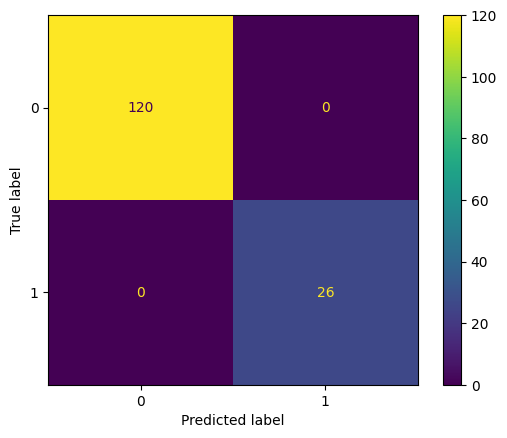

In [33]:
y_pred=model.predict(x_train)
predicted_classes = (y_train >= 0.5).astype(int)
conf_matrix = confusion_matrix(y_train, predicted_classes,labels=[0,1])

disp = ConfusionMatrixDisplay(conf_matrix)
disp.plot()

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


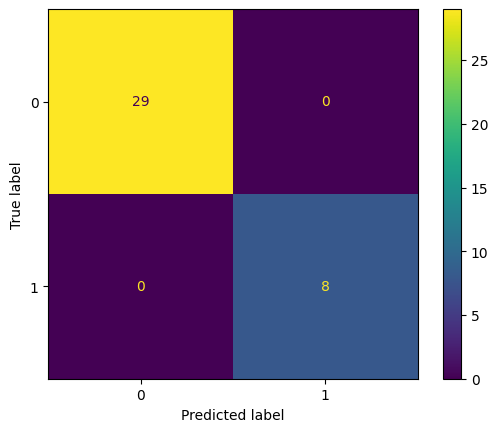

In [34]:
y_pred=model.predict(x_test)
predicted_classes = (y_test >= 0.5).astype(int)
conf_matrix = confusion_matrix(y_test, predicted_classes,labels=[0,1])

disp = ConfusionMatrixDisplay(conf_matrix)
disp.plot()

In [35]:
from sklearn.metrics import classification_report

# Assuming y_pred is your model's predictions
y_pred = model.predict(x_train) 

# Convert probabilities to class labels
y_pred = (y_pred >= 0.5).astype(int)

# Calculate precision, recall, and F1-score
print(classification_report(y_train, y_pred, target_names=['class 0', 'class 1']))

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
              precision    recall  f1-score   support

     class 0       0.84      0.78      0.81       120
     class 1       0.24      0.31      0.27        26

    accuracy                           0.70       146
   macro avg       0.54      0.55      0.54       146
weighted avg       0.73      0.70      0.71       146

